In [1]:
using Pkg
Pkg.DEFAULT_IO[] = stdout  # Julia 1.6.1 bug (Pkg.jl#2542)
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/Julia/doc/cscs_gpu_course/Project.toml`


In [2]:
using CUDA
using BenchmarkTools

# Kernel analysis and optimization

Once your application has been optimized, it's time to look at individual kernels. Initially, BenchmarkTools.jl and NSight Systems still are good tools to estimate the execution time of a kernel. For more insights, you can use the CUDA APIs, or use NSight Compute to dive deeply into a kernel's execution properties.

Optimizing algorithms and kernels for GPU execution is a very broad subject, impossible to cover in-depth during a single session like this.

Common optimizations include:

- algorithmic optimizations: using parallel algorithms instead of serial ones
- avoiding thread divergence: each thread in a warp should essentially execute the same instructions
- reducing global memory accesses: caching, or using fine-grained mechanisms to communicate between threads
- optimizing memory accesses: avoiding bank conflicts, making accesses coalescable

Instead of covering each of these, I'll focus on some demonstrating the tools, as well as cover some Julia-specific optimizations. For general kernel optimization guidelines, refer to the NVIDIA documentation or other on-line resources.

## Case study: Batched RMSE

Let's start with the batched RMSE kernel we developed in a previous notebook:

In [3]:
N = 16
A = CUDA.rand(1024,1024,N)
B = CUDA.rand(1024,1024,N)
C = CUDA.similar(A, N);

In [4]:
function rmse_kernel(C, A, B, Rmain, Rbatch)
    batch = blockIdx().x
    Ibatch = Rbatch[batch]
    
    # initialize the memory
    if threadIdx().x == 1
        C[batch] = 0
    end
    sync_threads()
    
    # grid-stride loop to process each batch in a block
    for i in threadIdx().x:blockDim().x:length(Rmain)
        Imain = Rmain[i]
        I = max(Imain, Ibatch)
        a = A[I]
        b = B[I]
        CUDA.@atomic C[batch] += (a-b)^2
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == 1
        C[batch] = sqrt(C[batch] / length(Rmain))
    end
    return
end

function rmse(C, A, B)
    Rmain = ntuple(i->i == ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    Rbatch = ntuple(i->i != ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    @cuda threads=256 blocks=N rmse_kernel(C, A, B, Rmain, Rbatch)
    return
end

rmse(C,A,B)
C

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40801775
 0.4076064
 0.4079894
 0.4083123
 0.40817732
 0.40769765
 0.40769112
 0.40794653
 0.40821344
 0.40828145
 0.40825048
 0.4085863
 0.40822002
 0.40820336
 0.4081819
 0.40789604

Let's benchmark in order to compare to the last notebook's implementation using array operations: 

In [5]:
@benchmark CUDA.@sync rmse(C, A, B)

BenchmarkTools.Trial: 234 samples with 1 evaluation.
 Range (min … max):  20.633 ms …  23.259 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     21.286 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.404 ms ± 487.528 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▃  ▃▂█▄▆▁ ▄▅▃    ▁ ▁ ▂▂                                 
  ▅▄▅▆▆▅█▆▇██████▆███▆▇▁▄█▆█▇██▇▃█▇▆▅▄▆▄▃▃▄▄▄▁▃▁▁▃▁▃▄▃▁▃▃▃▁▁▁▄ ▄
  20.6 ms         Histogram: frequency by time         22.9 ms <

 Memory estimate: 2.52 KiB, allocs estimate: 46.

How slow is that?! To understand what's going in here, we'll need to dive deeper into this kernel.

```
$ ncu --mode=launch julia
julia> using CUDA
CuArray([1])
```

Doing anything CUDA-related will hang the process, waiting to attach the Nsight Compute user interface (`ncu-ui`). There, in the Quick Launch, we can attach to the Julia process.

In the user interface:
- enable Auto Profile
- disable Break on API Error
- resume

As soon as we now launch our `rmse` function under `CUDA.@profile`, we'll see detailed information in the NSight Compute user interface window. There's many things that are bad with this kernel, but one stands out:

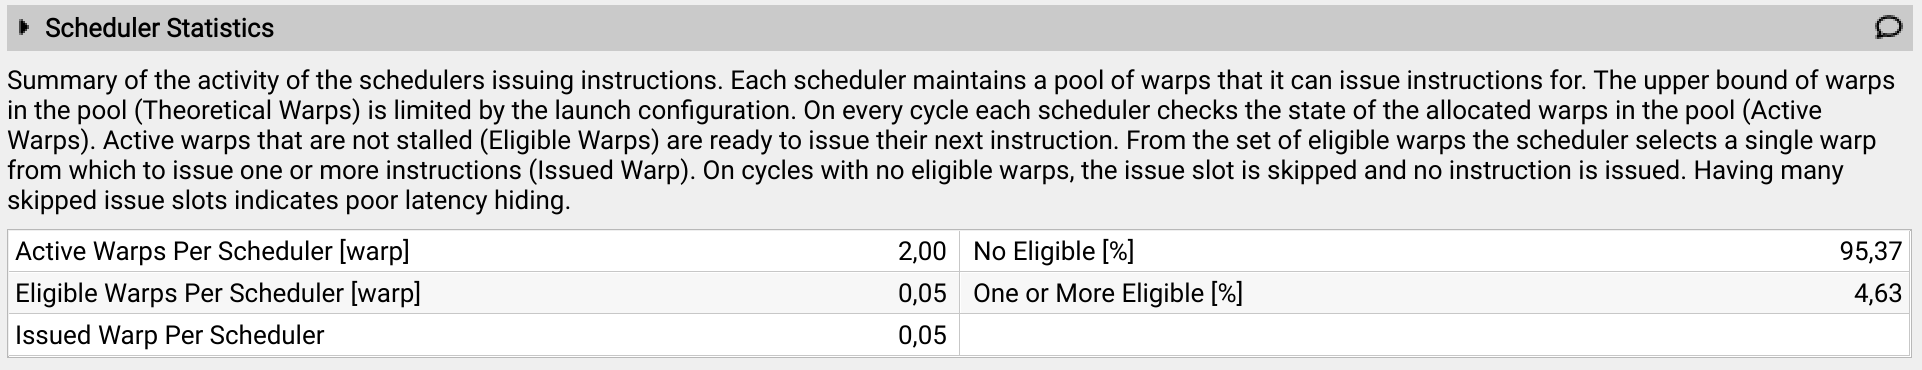

The high No Elegible count indicates that the GPU is unable to get threads to execute, so let's look at the stall reasons to know why:

<div class="alert alert-block alert-info">
    <strong>Note</strong>: It is only important to look at stall reasons when there aren't enough elegible warps; normally the GPU is able to hide stalls by switching to another warp.
</div>

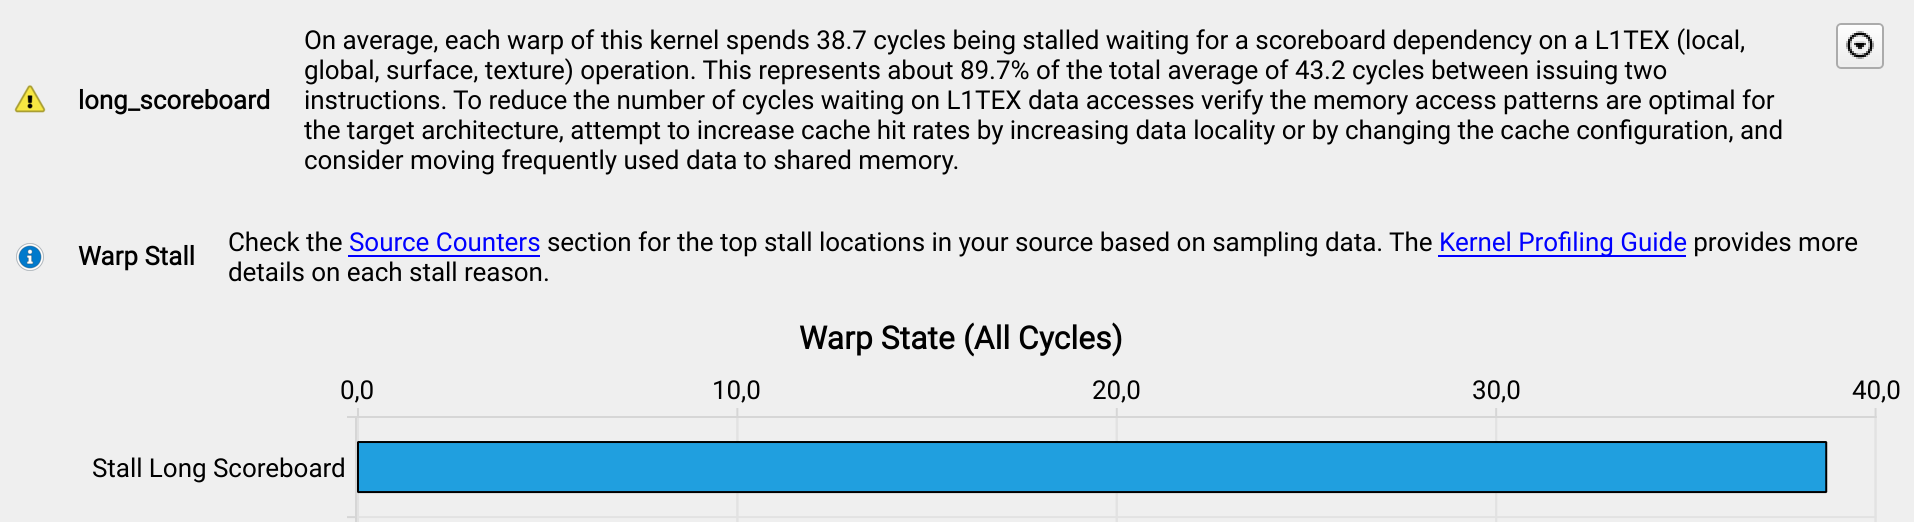


According to the [kernel profiling guide](https://docs.nvidia.com/nsight-compute/ProfilingGuide/index.html), long scoreboard stalls are typically caused by local or global memory loads. For information on exactly which instructions were stalling, let's look at the PTX source:

<div class="alert alert-block alert-info">
    <strong>Note</strong>: Debug info is a work in progress, so the PTX or SASS to source code mapping is currently incomplete.
</div>

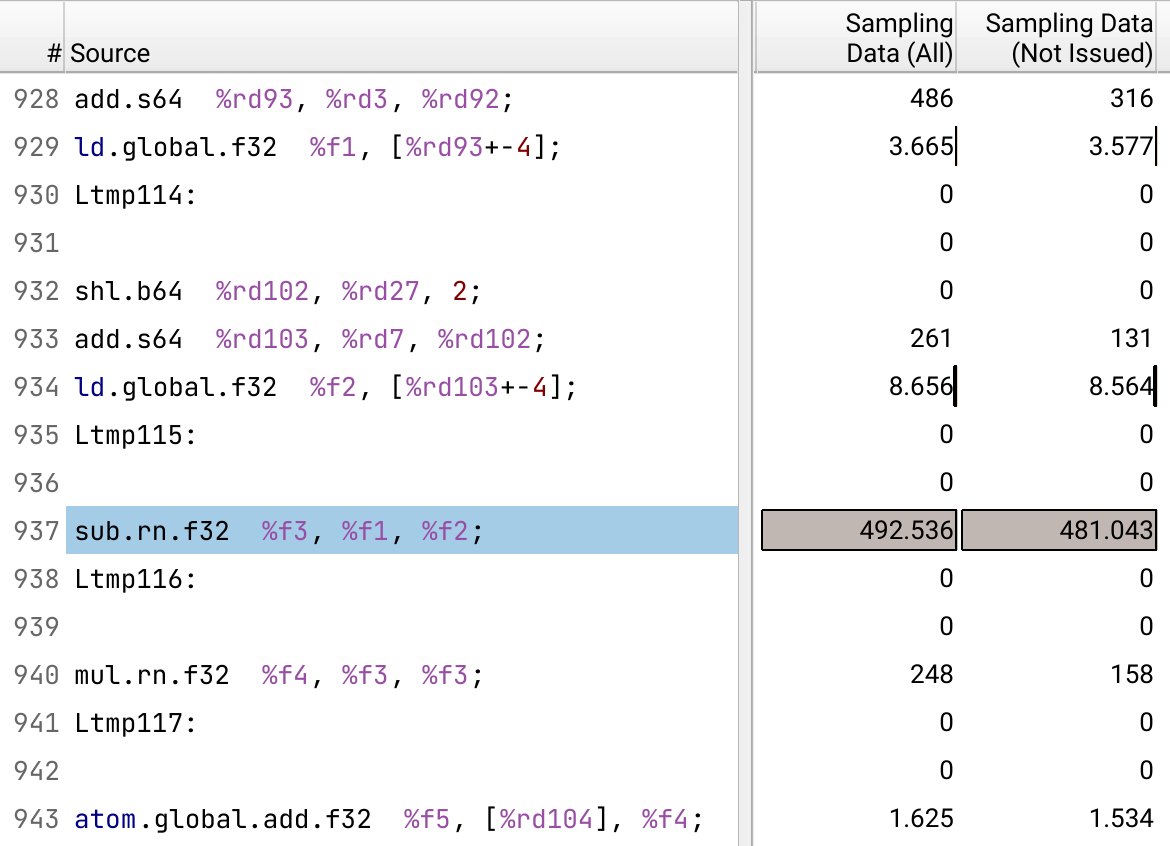

The culprit here is an instruction that uses global memory, right before performing a global atomic addition. That means it's fair to say this kernel is slow because of the atomic operation to global performed during every iteration by every thread. We could try aggregating in shared memory instead, but it's better to try and avoid the operation altogether.

There are several techniques to avoid this:

- perform the reduction in parallel
- use a shared memory buffer so that threads can communicate without intrinsics
- use warp-level intrinsics for even finer-grained communication

For more details on these techniques, refer to the following blog: https://developer.nvidia.com/blog/faster-parallel-reductions-kepler/

CUDA.jl implements these techniques for its `mapreducedim!` implementation, and although the individual steps of that reduction aren't a stable API we can still use them to avoid having to implement our own parallel reduction:

In [6]:
function rmse_kernel_opt(C::AbstractArray{T}, A, B, Rmain, Rbatch) where T
    batch = blockIdx().x
    Ibatch = Rbatch[batch]
    
    # grid-stride loop to process each batch in a block
    val = zero(T)
    for i in threadIdx().x:blockDim().x:length(Rmain)
        Imain = Rmain[i]
        I = max(Imain, Ibatch)
        a = A[I]
        b = B[I]
        val += CUDA.reduce_block(+, (a-b)^2, zero(T), #=shuffle=# Val(true))
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == 1
        C[batch] = sqrt(val / length(Rmain))
    end
    return
end;

In [7]:
function rmse_opt(C, A, B)
    Rmain = ntuple(i->i == ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    Rbatch = ntuple(i->i != ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    @cuda threads=256 blocks=N rmse_kernel_opt(C, A, B, Rmain, Rbatch)
    return
end;

In [8]:
b = @benchmark CUDA.@sync rmse_opt(C, A, B)
display(C)
b

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40813506
 0.4077217
 0.40811062
 0.40842807
 0.40829057
 0.40781704
 0.40781045
 0.40806067
 0.4083273
 0.40839127
 0.4083646
 0.40870053
 0.40833583
 0.40831563
 0.40829128
 0.40801162

BenchmarkTools.Trial: 1089 samples with 1 evaluation.
 Range (min … max):  4.218 ms …   5.947 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.496 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.585 ms ± 357.102 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▆█▆ ▁ ▃▁  ▁▅▄   ▂ ▁▂▃▄▃          ▂     ▂▁▁                  
  ██████▇███▇████▆██▇██████▇▇█▆▇▄█▇████▆▅████▇▅▄▅▇▅▆▆▆▇▅▃▅▄▄▆ █
  4.22 ms      Histogram: log(frequency) by time      5.56 ms <

 Memory estimate: 2.52 KiB, allocs estimate: 46.

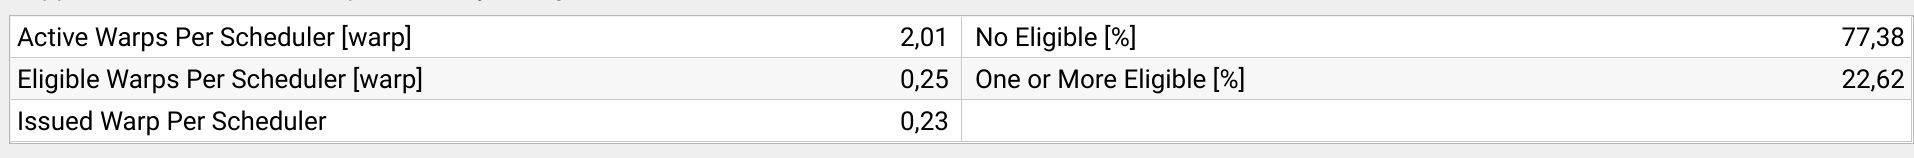

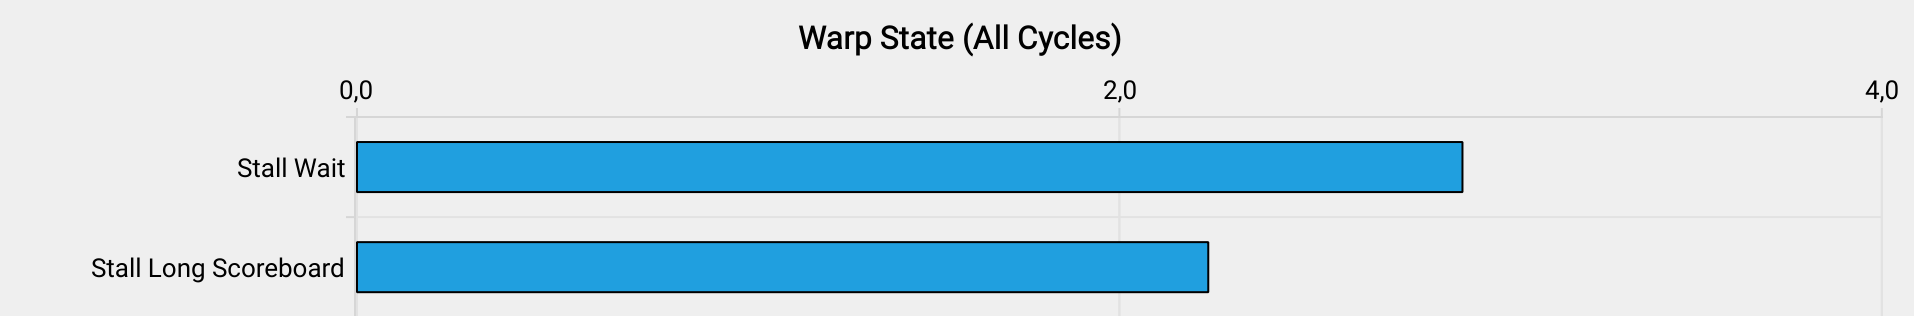

Much better! But still slower than CUDA.jl's reduction. One reason is the launch configuration: We're hard-coding the number of threads to 256, for maximal compatibility with older GPUs, and only launch as many blocks as the number of batches. Is that good enough?

In [9]:
kernel = @cuda launch=false rmse_kernel_opt(C, A, B, CartesianIndices(axes(A)), CartesianIndices(axes(A)))
config = launch_configuration(kernel.fun)

(blocks = 48, threads = 512)

The occupancy API tells use that we should use:
- 512 threads, to maximize occupancy within a SM
- at least 48 blocks, to maximize use of the GPU

Launching more threads is easy enough with a grid-stride loop, but launching more blocks needs a change to the index calculation. The reduction also needs to be adapted, since we may now be processing a single batch across multiple blocks. Lacking an efficient `reduce_grid`, the easiest solution is to re-introduce atomics. Those should not hurt performance, since they are only issues by a minimum of threads, and only once per kernel.

To split the hardware block index into one for additionally indexing the main iteration space, and the batch number, I chose to use the 3D-aspect of these hardware indices. Alternatively, it's possible to use `fldmod1` to decompose a single index based on the length of the iterator.

In [10]:
function rmse_kernel_opt(C::AbstractArray{T}, A, B, Rmain, Rbatch) where T
    batch = blockIdx().y
    Ibatch = Rbatch[batch]
    
    # grid-stride loop to process each batch in a block
    val = zero(T)
    i0 = threadIdx().x + (blockIdx().x-1)*blockDim().x
    for i in i0:(blockDim().x*gridDim().x):length(Rmain)
        Imain = Rmain[i]
        I = max(Imain, Ibatch)
        a = A[I]
        b = B[I]
        val += CUDA.reduce_block(+, (a-b)^2, zero(T), #=shuffle=# Val(true))
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == 1
        CUDA.@atomic C[batch] += val
    end
    return
end;

In [11]:
function rmse_opt(C, A, B)
    Rmain = ntuple(i->i == ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    Rbatch = ntuple(i->i != ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    
    fill!(C, zero(eltype(C)))
    @cuda threads=512 blocks=(48,N) rmse_kernel_opt(C, A, B, Rmain, Rbatch)
    C .= sqrt.(C ./ length(Rmain))
    return
end;

In [12]:
b = @benchmark CUDA.@sync rmse_opt(C, A, B)
display(C)
b

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40813524
 0.40772158
 0.40811074
 0.4084283
 0.40829065
 0.407817
 0.40781048
 0.40806067
 0.40832734
 0.40839136
 0.4083646
 0.4087007
 0.40833575
 0.40831536
 0.4082913
 0.40801182

BenchmarkTools.Trial: 5312 samples with 1 evaluation.
 Range (min … max):  868.830 μs …   2.041 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     879.930 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   937.077 μs ± 158.402 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▃▁▂▁      ▂               ▁                                 ▁
  ██████▇▅▁▁▄▄██▅▅██▅▄▃▇▆▃▄▆▆████▇█▄▅█▆▆▇▆▅▄▅▆▆▆▇▇▆▁▃▁▁▃▄▃▃▄▃▃▇ █
  869 μs        Histogram: log(frequency) by time       1.66 ms <

 Memory estimate: 3.97 KiB, allocs estimate: 71.

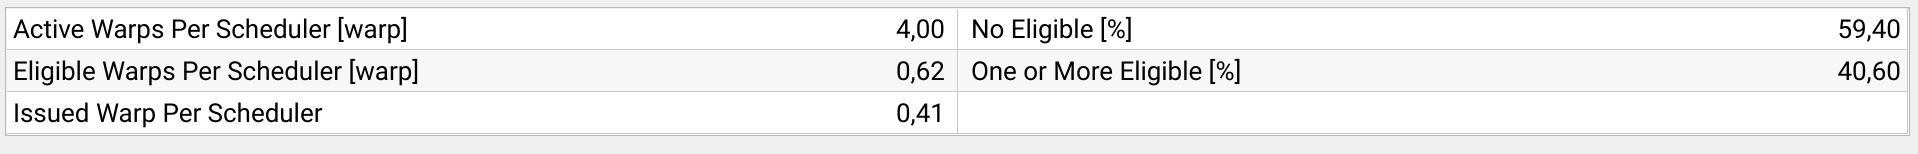

Much better. Let's actually use the launch configuration API at run time to make sure we use the best possible configuration for the GPU at hand:

In [13]:
function rmse_opt(C, A, B)
    Rmain = ntuple(i->i == ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    Rbatch = ntuple(i->i != ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    
    kernel = @cuda launch=false rmse_kernel_opt(C, A, B, Rmain, Rbatch)
    config = launch_configuration(kernel.fun)
    blocks_x = min(config.blocks, length(Rmain))
    threads = min(config.threads, cld(length(Rmain), blocks_x))
    blocks = (blocks_x, N)
    
    fill!(C, zero(eltype(C)))
    kernel(C, A, B, Rmain, Rbatch; threads, blocks)
    C .= sqrt.(C ./ length(Rmain))
    return
end;

In [14]:
b = @benchmark CUDA.@sync rmse_opt(C, A, B)
display(C)
b

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40813527
 0.40772155
 0.40811077
 0.4084283
 0.40829062
 0.40781704
 0.40781045
 0.4080607
 0.4083273
 0.40839136
 0.4083646
 0.4087007
 0.40833572
 0.40831533
 0.40829137
 0.40801182

BenchmarkTools.Trial: 5137 samples with 1 evaluation.
 Range (min … max):  864.220 μs …   5.523 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     941.039 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   969.315 μs ± 174.493 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▇▁ ▂█▂ ▂▂                    ▁                               ▁
  ██████████▅▇▇▄▄▇▇▅▇▇▇▃▆▄▃▄▆▄▄▆█▄▄▄▄▅▄▄▅▃▅▆▆██▇▇▆▆▄▄▁▄▁▃▅▆▅▇▆▆ █
  864 μs        Histogram: log(frequency) by time       1.73 ms <

 Memory estimate: 4.02 KiB, allocs estimate: 74.

Now we are getting close to the performance we'd expect. For the remaining optimizations, we will need to have a look at the generated code. It's recommended to start out with the LLVM code, which is the most readable:

In [ ]:
@device_code_llvm debuginfo=:none rmse_opt(C,A,B)

Generally, for GPU kernels we want straight-line code, minimizing the amount of branches, while also reducing the amount of data that needs to be kept in registers. You can easily inspect the former using the compiled kernel object:

In [16]:
kernel = @cuda launch=false rmse_kernel_opt(C, A, B, CartesianIndices(axes(A)), CartesianIndices(axes(A)))
CUDA.registers(kernel)

98

It's important to minimize the amount of registers, because it determines how much threads can be launched as part of a single block:

In [17]:
CUDA.maxthreads(kernel)

512

Note that this is the same number as reported by the occupancy API.

If we now look closer at the generated code, we can quickly see a bunch of branches because of bounds checking:

```
L33:                                              ; preds = %entry
  %39 = icmp sgt i64 %.fca.0.0.0.extract, 0
  %40 = icmp sgt i64 %.fca.0.1.0.extract, 0
  %41 = select i1 %40, i64 %.fca.0.1.0.extract, i64 0
  %42 = add nsw i64 %31, -1
  br i1 %39, label %pass, label %fail

L63:                                              ; preds = %pass2
  %43 = getelementptr inbounds [1 x [3 x [1 x i64]]], [1 x [3 x [1 x i64]]]* %21, i64 0, i64 0, i64 0
  call fastcc void @julia_throw_boundserror_8011([1 x i64] %state)
  unreachable

L69:                                              ; preds = %pass2
  %44 = icmp slt i64 %178, 1
  %45 = icmp sgt i64 %178, %.fca.0.1.0.extract
  %46 = or i1 %44, %45
  br i1 %46, label %L77, label %L83
```

Typically, those function calls also require data to be prepared and put into registers, so eliminating bounds checks should both remove unneeded branches as well as reduce register pressure:

In [18]:
function rmse_kernel_opt(C::AbstractArray{T}, A, B, Rmain, Rbatch) where T
    batch = blockIdx().y
    Ibatch = @inbounds Rbatch[batch]
    
    # grid-stride loop to process each batch in a block
    val = zero(T)
    i0 = threadIdx().x + (blockIdx().x-1)*blockDim().x
    @inbounds for i in i0:(blockDim().x*gridDim().x):length(Rmain)
        Imain = Rmain[i]
        I = max(Imain, Ibatch)
        a = A[I]
        b = B[I]
        val += CUDA.reduce_block(+, (a-b)^2, zero(T), #=shuffle=# Val(true))
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == 1
        @inbounds CUDA.@atomic C[batch] += val
    end
    return
end;

In [19]:
b = @benchmark CUDA.@sync rmse_opt(C, A, B)
display(C)
b

16-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.40821084
 0.4077869
 0.4081944
 0.4085028
 0.40836316
 0.40790057
 0.4078742
 0.4081358
 0.40840012
 0.408465
 0.40843874
 0.40876645
 0.40841168
 0.4083849
 0.40837207
 0.40808266

BenchmarkTools.Trial: 6289 samples with 1 evaluation.
 Range (min … max):  726.541 μs …   8.130 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     746.681 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   790.664 μs ± 169.792 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂██▁▂▃           ▁▁  ▁             ▁▁             ▁           ▁
  ███████▅█▅▁▃▅▃▆▆▆██▄▇██▆▆▄▁▃▃▃▁▁▄▁███▇▅▄▅▅▆▇▆██▇▆▇█▇▇▅▄▃▃▄▆▆▆ █
  727 μs        Histogram: log(frequency) by time       1.32 ms <

 Memory estimate: 4.02 KiB, allocs estimate: 74.

In [20]:
kernel = @cuda launch=false rmse_kernel_opt(C, A, B, CartesianIndices(axes(A)), CartesianIndices(axes(A)))
CUDA.registers(kernel)

90

In [21]:
CUDA.maxthreads(kernel)

640

Another common source of register pressure is the use of 64-bit integers where only 32-bits are required. For example, the hardware's indices are 32-bit integers, but Julia's literals here are Int64's which results in expressions like `blockIdx().x-1` to be promoted to 64-bits integers. We can avoid this by using `Int32` indices:

In [22]:
function rmse_kernel_opt(C::AbstractArray{T}, A, B, Rmain, Rbatch) where T
    batch = blockIdx().y
    Ibatch = @inbounds Rbatch[batch]
    
    # grid-stride loop to process each batch in a block
    val = zero(T)
    i0 = threadIdx().x + (blockIdx().x-Int32(1))*blockDim().x
    @inbounds for i in i0:(blockDim().x*gridDim().x):length(Rmain)
        Imain = Rmain[i]
        I = max(Imain, Ibatch)
        a = A[I]
        b = B[I]
        val += CUDA.reduce_block(+, (a-b)^2, zero(T), #=shuffle=# Val(true))
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == Int32(1)
        @inbounds CUDA.@atomic C[batch] += val
    end
    return
end

rmse_kernel_opt (generic function with 1 method)

In [23]:
kernel = @cuda launch=false rmse_kernel_opt(C, A, B, CartesianIndices(axes(A)), CartesianIndices(axes(A)))
CUDA.registers(kernel)

88

If we look even closer at the generated code, there is another exception being thrown from the `div` function in Base:

```
;  @ In[22]:3 within `rmse_kernel_opt'
; ┌ @ abstractarray.jl:1170 within `getindex'
; │┌ @ abstractarray.jl:1209 within `_getindex'
; ││┌ @ abstractarray.jl:1216 within `_to_subscript_indices'
; │││┌ @ abstractarray.jl:1238 within `_unsafe_ind2sub'
; ││││┌ @ abstractarray.jl:2016 within `_ind2sub' @ abstractarray.jl:2054
; │││││┌ @ abstractarray.jl:2067 within `_ind2sub_recurse'
; ││││││┌ @ abstractarray.jl:2074 within `_div'
; │││││││┌ @ int.jl:261 within `div'
          call fastcc void @gpu_report_exception(i64 ptrtoint ([10 x i8]* @exception121 to i64))
          call fastcc void @gpu_signal_exception([1 x i64] %state)
          call void asm sideeffect "exit;", ""() #5
          unreachable
```

In [ ]:
@device_code_llvm rmse_opt(C,A,B)

We cannot simplify avoid this exception using an `@inbounds`-like macro, or by using differently-typed indices. However, if we look at the definition of `div` we can see that the exception is thrown when the divisor is 0. Here, the divisor is the size of the abstract array being indexed, and we can tell LLVM it can never be 0 using the `assume` intrinsic:

In [25]:
using LLVM, LLVM.Interop
function rmse_kernel_opt(C::AbstractArray{T}, A, B, Rmain, Rbatch) where T
    batch = blockIdx().y
    assume.(size(Rbatch) .> 0)
    Ibatch = @inbounds Rbatch[batch]
    
    # grid-stride loop to process each batch in a block
    val = zero(T)
    i0 = threadIdx().x + (blockIdx().x-Int32(1))*blockDim().x
    assume.(size(Rmain) .> 0)
    @inbounds for i in i0:(blockDim().x*gridDim().x):length(Rmain)
        Imain = Rmain[i]
        I = max(Imain, Ibatch)
        a = A[I]
        b = B[I]
        val += CUDA.reduce_block(+, (a-b)^2, zero(T), #=shuffle=# Val(true))
    end    
    sync_threads()
    
    # finalize the computation
    if threadIdx().x == Int32(1)
        @inbounds CUDA.@atomic C[batch] += val
    end
    return
end;

In [26]:
kernel = @cuda launch=false rmse_kernel_opt(C, A, B, CartesianIndices(axes(A)), CartesianIndices(axes(A)))
CUDA.registers(kernel)

82

In [27]:
CUDA.maxthreads(kernel)

640

The IR doesn't contain any exceptions anymore now. We can also have a look at even lower-level code:

In [ ]:
@device_code_ptx  rmse_opt(C,A,B)

In [ ]:
@device_code_sass rmse_opt(C,A,B)

In [30]:
@benchmark CUDA.@sync rmse_opt(C, A, B)

BenchmarkTools.Trial: 6374 samples with 1 evaluation.
 Range (min … max):  718.201 μs …   1.481 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     739.371 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   780.484 μs ± 109.466 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▅█▅▁▂▃▁   ▁           ▁▂        ▁            ▁            ▁▁ ▁
  ▅███████▅▄▆█▄▃▃▄▃▆▆▅▆▇███▆▅▄▄▅▆▆▆██▆▅▃▁▁▃▁▁▃▆███▇▅▆▅▄▃▁▁▃▆███ █
  718 μs        Histogram: log(frequency) by time       1.19 ms <

 Memory estimate: 4.02 KiB, allocs estimate: 74.

Note that optimizing for register pressure is important. According to NSight Compute, we're only using half of what the GPU is capable of:

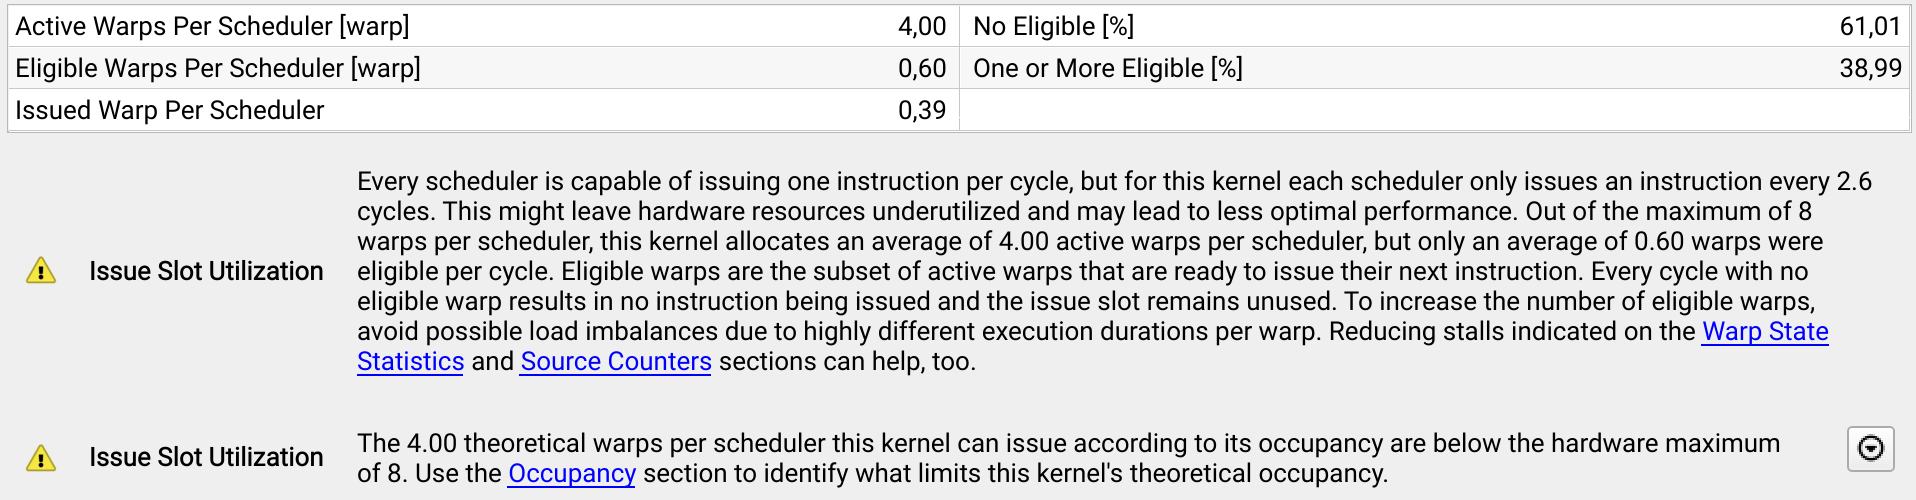

According to the occupancy section, this is caused by register pressure:

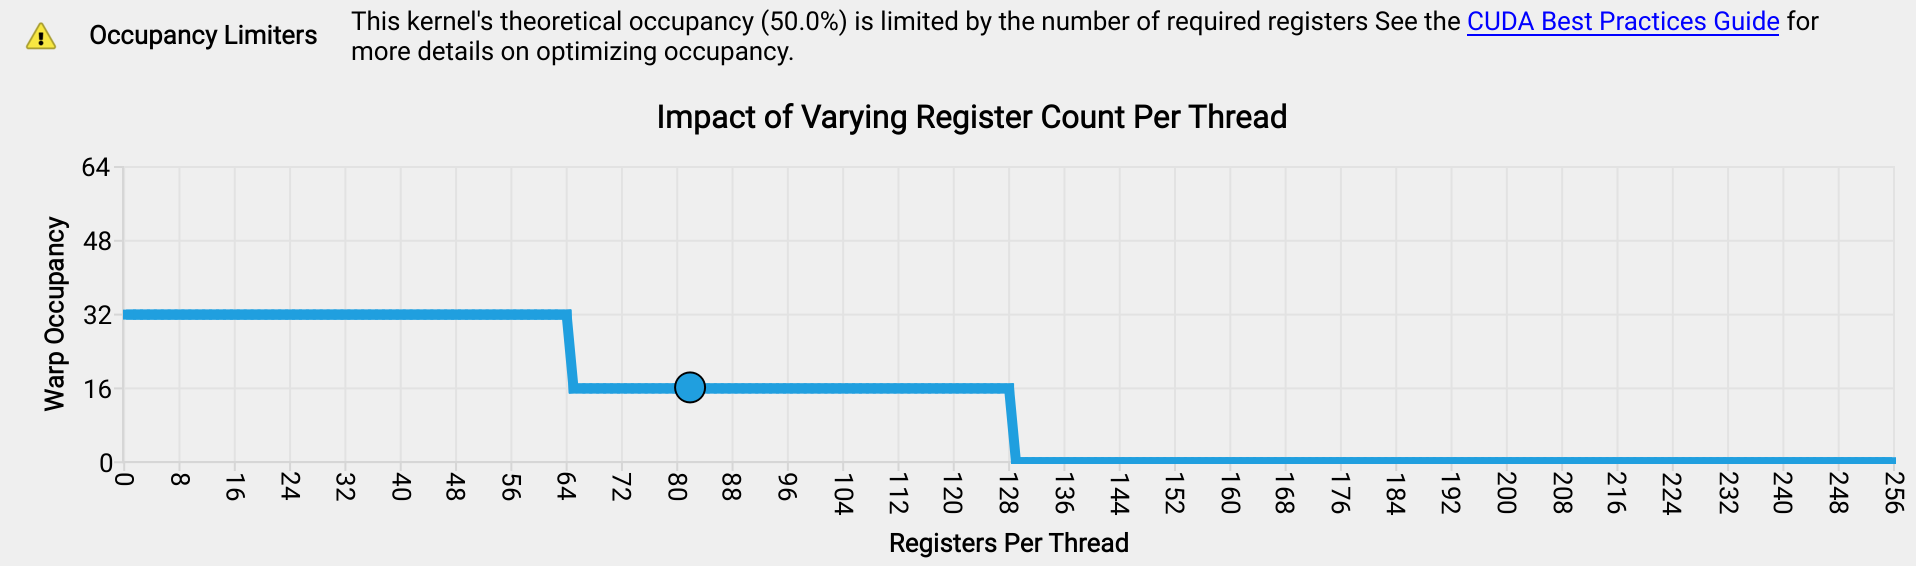

There is another trick we can try: artificially reducing register pressure by spilling to local memory. This is a compiler transformation by `ptxas`, and enabled by setting the `maxregs` keyword to `@cuda`:

In [31]:
kernel = @cuda launch=false maxregs=64 rmse_kernel_opt(C, A, B, CartesianIndices(axes(A)), CartesianIndices(axes(A)))
CUDA.registers(kernel)

64

In [32]:
CUDA.memory(kernel)

(local = 24, shared = 128, constant = 0)

In [33]:
kernel = @cuda launch=false rmse_kernel_opt(C, A, B, CartesianIndices(axes(A)), CartesianIndices(axes(A)))
CUDA.memory(kernel)

(local = 8, shared = 128, constant = 0)

<div class="alert alert-block alert-warning">
    <strong>Warning</strong>: Local memory is essentially per-thread global memory, which easily degrades performance because of the added memory transactions.
</div>

Here, that tradeoff is worth it, because lowering the register usage to 64 should double effective GPU usage.

In [34]:
function rmse_opt(C, A, B)
    Rmain = ntuple(i->i == ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    Rbatch = ntuple(i->i != ndims(A) ? Base.OneTo(1) : axes(A)[i], ndims(A)) |> CartesianIndices
    
    kernel = @cuda launch=false maxregs=64 rmse_kernel_opt(C, A, B, Rmain, Rbatch)
    config = launch_configuration(kernel.fun)
    blocks_x = min(config.blocks, length(Rmain))
    threads = min(config.threads, cld(length(Rmain), blocks_x))
    blocks = (blocks_x, N)
    
    fill!(C, zero(eltype(C)))
    kernel(C, A, B, Rmain, Rbatch; threads, blocks)
    C .= sqrt.(C ./ length(Rmain))
    return
end;

In [35]:
@benchmark CUDA.@sync rmse_opt(C, A, B)

BenchmarkTools.Trial: 7256 samples with 1 evaluation.
 Range (min … max):  632.993 μs …   1.364 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     647.992 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   684.905 μs ± 102.928 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃█▇▂▁▃▄               ▁▂▁    ▁                ▁▁           ▁▂ ▁
  ████████▆▆▆▄▃▅▃▁▁▃▆▆▇████▆▃▅▆██▆▃▁▁▁▁▁▁▁▃▃▃▃▃▆██▇▇▇▇▄▄▁▁▁▅▆██ █
  633 μs        Histogram: log(frequency) by time        1.1 ms <

 Memory estimate: 4.02 KiB, allocs estimate: 74.

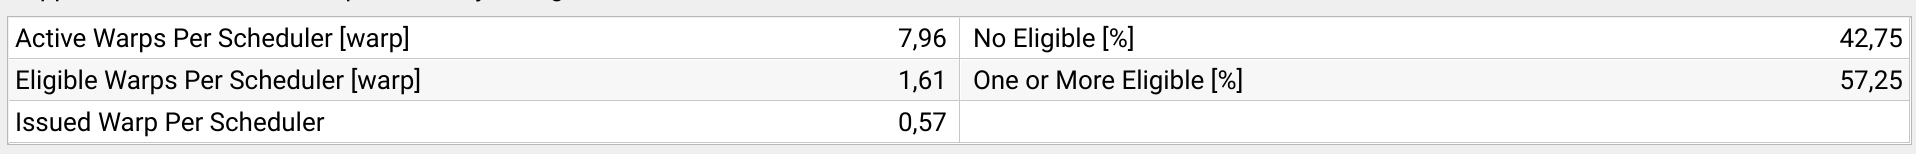

It is not recommended to include such optimizations in generic code: Changing kernel input types, let alone passing different anonymous functions, can radically change the performance characteristics of a kernel.

Finally, a comparison of high-level usage statistics between the initial and final kernel:

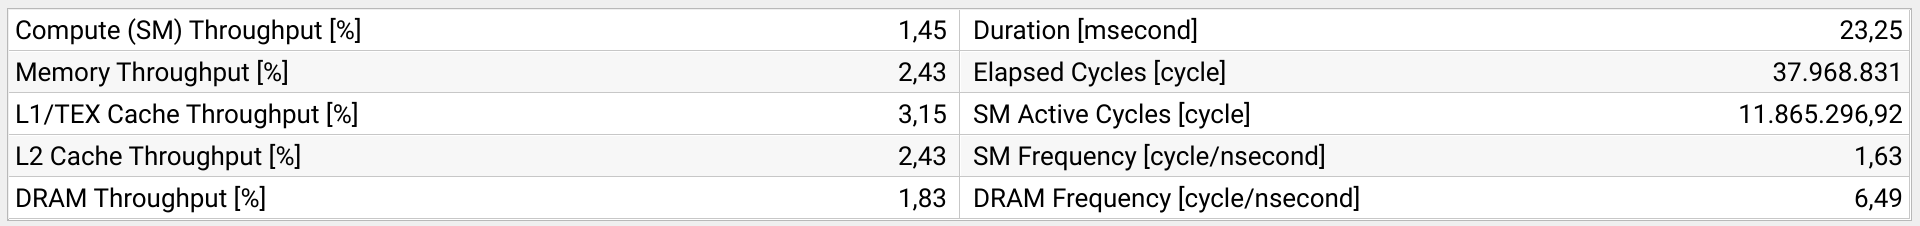

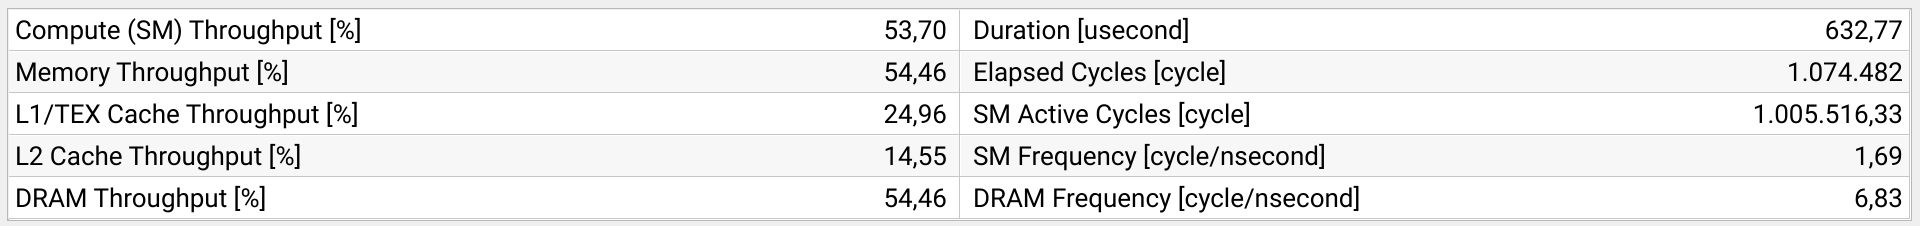

## Memory coalescing

AKA: Is CUDA.jl row or column major?
Julia is column major, and CUDA.jl follows those conventions.

With CPU code, the recommendation is that the leftmost index should be the one changing the quickliest (i.e. in the inner loop). That's because incrementing the leftmost index moves to the next location in memory, benefiting from spatial locality.

With GPUs, spatial locality is important as well, but you it doesn't matter across iterations in a loop but across the warp. That means consecutive threads in a warp should be accessing consecutive locations in memory.

For example, let's look at a simple `axpy` kernel:

In [36]:
a = rand(Float32)
X = rand(Float32, 512, 512)
Y = rand(Float32, 512, 512);

In [37]:
import LinearAlgebra

function axpy!(a, X, Y)
    size(X) == size(Y) || throw(ArgumentError("$X and $Y should have equal size"))

    function kernel(a, X, Y)
        i = blockIdx().x
        j = threadIdx().x
        
        @inbounds Y[i,j] = a*X[i,j] + Y[i,j]
        
        return
    end
    
    @cuda threads=size(X,2) blocks=size(X,1) kernel(a, X, Y)
    
    return Y
end

dX = CuArray(X)
dY = CuArray(Y)

axpy!(a, dX, dY)
LinearAlgebra.axpy!(a, X, Y)

Y ≈ Array(dY)

true

In [38]:
@benchmark CUDA.@sync axpy!(a, dX, dY)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  30.930 μs … 869.629 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     31.649 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   34.328 μs ±  32.639 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▁▃▅▃█▇▇▄▆▄▁                                           
  ▂▂▂▃▄▅▆▆█████████████▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂ ▄
  30.9 μs         Histogram: frequency by time         33.8 μs <

 Memory estimate: 288 bytes, allocs estimate: 3.

This kernel doesn't follow the above guideline. By not using the thread index as the leftmost index, consecutive threads in a warp won't be accessing consecutive locations in memory! Let's fix that:

In [39]:
function axpy!(a, X, Y)
    size(X) == size(Y) || throw(ArgumentError("$X and $Y should have equal size"))

    function kernel(a, X, Y)
        i = threadIdx().x
        j = blockIdx().x
        
        @inbounds Y[i,j] = a*X[i,j] + Y[i,j]
        
        return
    end
    
    @cuda threads=size(X,1) blocks=size(X,2) kernel(a, X, Y)
    
    return Y
end

dX = CuArray(X)
dY = CuArray(Y)

axpy!(a, dX, dY)
LinearAlgebra.axpy!(a, X, Y)

Y ≈ Array(dY)

true

In [40]:
@benchmark CUDA.@sync axpy!(a, dX, dY)

BenchmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):   8.780 μs … 225.484 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.366 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.161 μs ±  10.459 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                 ▁▃▄▅▇██▆▄▂▂▂▁                                  
  ▂▁▁▂▁▂▂▂▂▂▂▃▃▅▇██████████████▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▄
  8.78 μs         Histogram: frequency by time         10.4 μs <

 Memory estimate: 288 bytes, allocs estimate: 3.

Note that this isn't how we'd implement an operation like this. Instead, we'd use linear indexing for simplicity (retaining the above property) together with a grid-stride loop and use of the launch configuration to optimize GPU usage:

In [41]:
import LinearAlgebra

function axpy!(a, X, Y)
    size(X) == size(Y) || throw(ArgumentError("$X and $Y should have equal size"))

    function kernel(a, X, Y)
        i0 = threadIdx().x + (blockIdx().x-1) * blockDim().x
        
        # grid-stride loop
        for i in i0:blockDim().x*gridDim().x:length(Y)
            @inbounds Y[i] = a*X[i] + Y[i]
        end
        
        return
    end
    
    kernel = @cuda launch=false kernel(a, X, Y)
    config = launch_configuration(kernel.fun)
    threads = min(config.threads, length(X))
    blocks = min(config.blocks, cld(length(X), threads))
    
    #println("""Need to process $(length(X)) items, doing so using
    #           - $(threads) threads (API recommended $(config.threads))
    #           - $blocks blocks (API recommended $(config.blocks), needed $(cld(length(X), blocks)) without a grid-stride loop)""")
    
    kernel(a, X, Y; threads, blocks)
    
    return Y
end

a = rand(Float32)
X = rand(Float32, 512, 512)
Y = rand(Float32, 512, 512)

dX = CuArray(X)
dY = CuArray(Y)

axpy!(a, dX, dY)
LinearAlgebra.axpy!(a, X, Y)

Y ≈ Array(dY)

true

In [42]:
@benchmark CUDA.@sync axpy!(a, dX, dY)

BenchmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):   8.626 μs … 301.523 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.140 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.044 μs ±  11.614 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

           ▂▅▆█▆▆▄▁                                             
  ▁▁▁▁▂▂▃▄▇█████████▇▆▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁ ▃
  8.63 μs         Histogram: frequency by time         10.8 μs <

 Memory estimate: 320 bytes, allocs estimate: 5.